In [1]:
import pandas as pd
import numpy as np

In [2]:
print(pd.__version__)
print(np.__version__)

1.4.3
1.21.2


##### points to notice



- visulizing data
- digging into the data

As a more involved example of working with some time series data, let’s take a look at
bicycle counts on Seattle’s Fremont Bridge. This data comes from an automated bicy‐
cle counter, installed in late 2012, which has inductive sensors on the east and west
sidewalks of the bridge.

In [3]:
data = pd.read_csv('../Data/Seattle_Bicycle_Counts/Fremont_Bridge_Bicycle_Counter.csv', index_col='Date', parse_dates=True)
data.head()

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2022-08-01 00:00:00,23.0,7.0,16.0
2022-08-01 01:00:00,12.0,5.0,7.0
2022-08-01 02:00:00,3.0,0.0,3.0
2022-08-01 03:00:00,5.0,2.0,3.0
2022-08-01 04:00:00,10.0,2.0,8.0


For convenience, we’ll further process this dataset by shortening the column names
and adding a “Total” column:

In [4]:
data.columns = ['Total', 'West', 'East']
data.head()

,Total,West,East
Date,,,
2022-08-01 00:00:00,23.0,7.0,16.0
2022-08-01 01:00:00,12.0,5.0,7.0
2022-08-01 02:00:00,3.0,0.0,3.0
2022-08-01 03:00:00,5.0,2.0,3.0
2022-08-01 04:00:00,10.0,2.0,8.0


In [5]:
data.dropna().describe()

,Total,West,East
count,87586.000000,87586.000000,87586.000000
mean,107.240849,48.086623,59.154226
std,134.790561,61.573965,83.567491
min,0.000000,0.000000,0.000000
25%,13.000000,6.000000,7.000000
50%,60.000000,27.000000,30.000000
75%,144.000000,66.000000,75.000000
max,1097.000000,698.000000,850.000000


##### Visualizing the data

We can gain some insight into the dataset by visualizing it. Let’s start by plotting the
raw data

In [6]:
import matplotlib.pyplot as plt
import seaborn;seaborn.set()

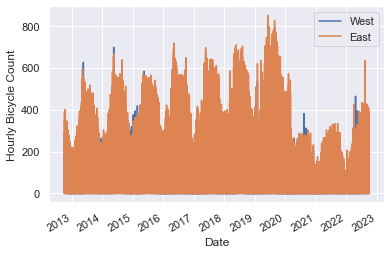

In [7]:
data.loc[:,['West', 'East']].plot()
plt.ylabel('Hourly Bicycle Count');

The ~25,000 hourly samples are far too dense for us to make much sense of. We can
gain more insight by resampling the data to a coarser grid. Let’s resample by week

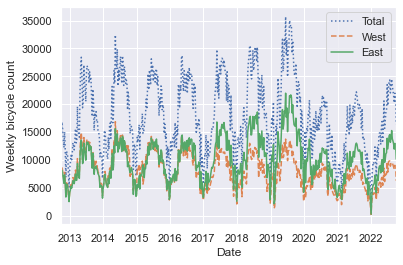

In [8]:
weekly = data.resample('W').sum()
weekly.plot(style=[':', '--', '-'])
plt.ylabel('Weekly bicycle count');

Another way that comes in handy for aggregating the data is to use a rolling mean,
utilizing the pd.rolling_mean() function. Here we’ll do a 30-day rolling mean of our
data, making sure to center the window (Figure 3-13):

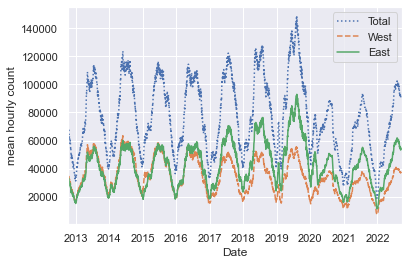

In [9]:
daily = data.resample('D').sum()
daily.rolling(30, center=True).sum().plot(style=[':', '--', '-'])
plt.ylabel('mean hourly count');

The jaggedness of the result is due to the hard cutoff of the window. We can get a
smoother version of a rolling mean using a window function—for example, a Gaus‐
sian window. The following code (visualized in Figure 3-14) specifies both the width
of the window (we chose 50 days) and the width of the Gaussian within the window
(we chose 10 days):

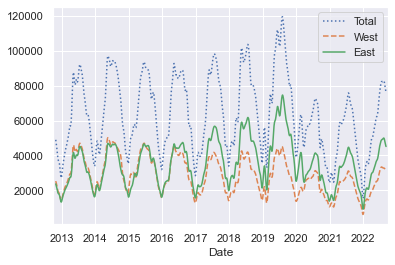

In [10]:
daily.rolling(50, center=True,
              win_type='gaussian').sum(std=10).plot(style=[':', '--', '-']);

##### Digging into the data

While the smoothed data views in Figure 3-14 are useful to get an idea of the general
trend in the data, they hide much of the interesting structure. For example, we might
want to look at the average traffic as a function of the time of day. We can do this
using the GroupBy functionality discussed in “Aggregation and Grouping”

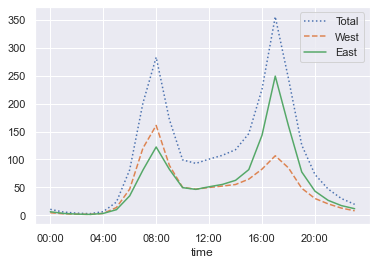

In [11]:
by_time = data.groupby(data.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, style=[':', '--', '-']);

We also might be curious about how things change based on the day of the week.
Again, we can do this with a simple groupby (Figure 3-16):

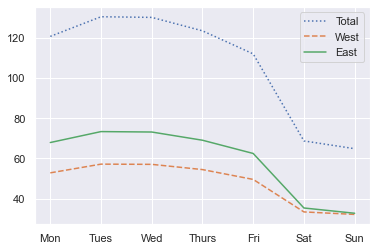

In [13]:
by_weekday = data.groupby(data.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(style=[':', '--', '-']);

This shows a strong distinction between weekday and weekend totals, with around
twice as many average riders crossing the bridge on Monday through Friday than on
Saturday and Sunday. <br>

With this in mind, let’s do a compound groupby and look at the hourly trend on
weekdays versus weekends. We’ll start by grouping by both a flag marking the week‐
end, and the time of day:

In [14]:
weekend = np.where(data.index.weekday < 5, 'Weekday', 'Weekend')
by_time = data.groupby([weekend, data.index.time]).mean()

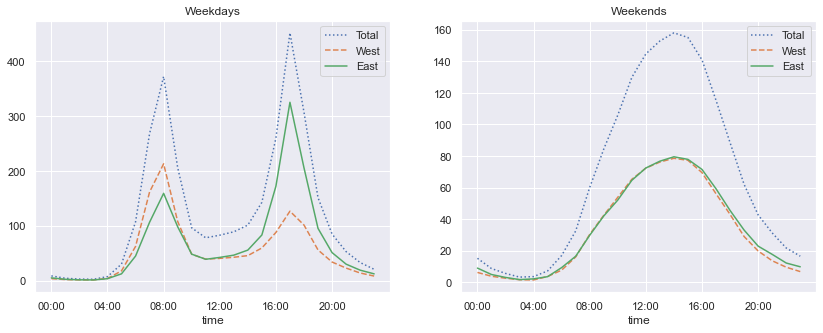

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',
                                   xticks=hourly_ticks, style=[':', '--', '-'])
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',
                                   xticks=hourly_ticks, style=[':', '--', '-']);

The result is very interesting: we see a bimodal commute pattern during the work
week, and a unimodal recreational pattern during the weekends. It would be interest‐
ing to dig through this data in more detail, and examine the effect of weather, temper‐
ature, time of year, and other factors on people’s commuting patterns; for further
discussion, see my blog post “Is Seattle Really Seeing an Uptick In Cycling?”, which
uses a subset of this data. We will also revisit this dataset in the context of modeling in
“In Depth: Linear Regression”.